In [1]:
import numpy as np
import torch
import torch.nn as nn                                                
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import seaborn as sns

In [2]:
def batch_to_canny(tensor_batch):
    batch = []
    tensor_batch = tensor_batch.view(-1,tensor_batch.size()[-2], tensor_batch.size()[-1] )
    for image in tensor_batch:

        foo = (image.numpy().astype(np.uint8))
        ed = np_arr_to_canny_edges(foo)
        batch.append(ed)

    foo = torch.Tensor(batch)
    foo = foo.view(-1,1, foo.size()[1], foo.size()[2])
    return foo
def np_arr_to_canny_edges(im_arr):
    ed = cv2.Canny(im_arr.astype(np.uint8), 100,100)
    return ed

In [294]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 10, 3),
            nn.MaxPool2d(5,5),
            nn.ReLU(inplace=True),
            nn.Conv2d(10, 10, 3),
            nn.MaxPool2d(3,3),
            nn.ReLU(inplace=True),
            nn.Conv2d(10, 10, 3),
            nn.ReLU(inplace=True),
        )

        self.classifier = nn.Sequential(
            nn.Linear(150, 110),
            nn.ReLU(inplace=True),
            nn.Linear(110, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 4),
        )
        
    def forward(self, x):
        x = batch_to_canny(x)

        x = self.features(x)
        x = x.view(x.size(0), -1)

        x = self.classifier(x)
        return x

cellnet_1 = Net()


In [305]:
cellnet_1.load_state_dict(torch.load("cellnet_1.pt"))

<All keys matched successfully>

In [274]:
def preprocess(img_path, show = False):
    im = Image.open(img_path).convert("L")
    im = im.resize((120, 90))
    np_im = np.array(im)
    if show == True:
        plt.imshow(np_im)
        plt.xlabel("Original image", fontsize = 20)
        plt.show()
    inp = torch.from_numpy(np_im).unsqueeze(0).unsqueeze(0).float()  ## tensor ready to be fed to nn 
    
    return inp 



In [275]:
def show_layers(model, image_tensor, layer_number):
    features = nn.Sequential(*list(cellnet_1.children())[:layer_number])
    mm = features(inp).detach().numpy()
    images = []
    for i in mm[0]:
        images.append(i)
    f = plt.figure(figsize = (35,20))

    for m in range (1,len(images)):
        f.add_subplot(1,len(images), m)

        plt.imshow(images[m], cmap = 'gnuplot2', label = "Canny")
    plt.show()

In [277]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
    layer = model.features[layer_num]
  
  #checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
        weight_tensor = model.features[layer_num].weight.data

        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor)
            else:
                plot_filters_single_channel(weight_tensor)

        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                print("Can only plot weights with three channels with single channel = False")

    else:
        print("Can only visualize layers which are convolutional")
        

def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()


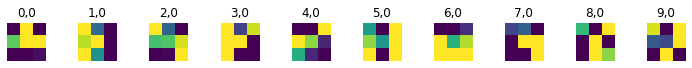

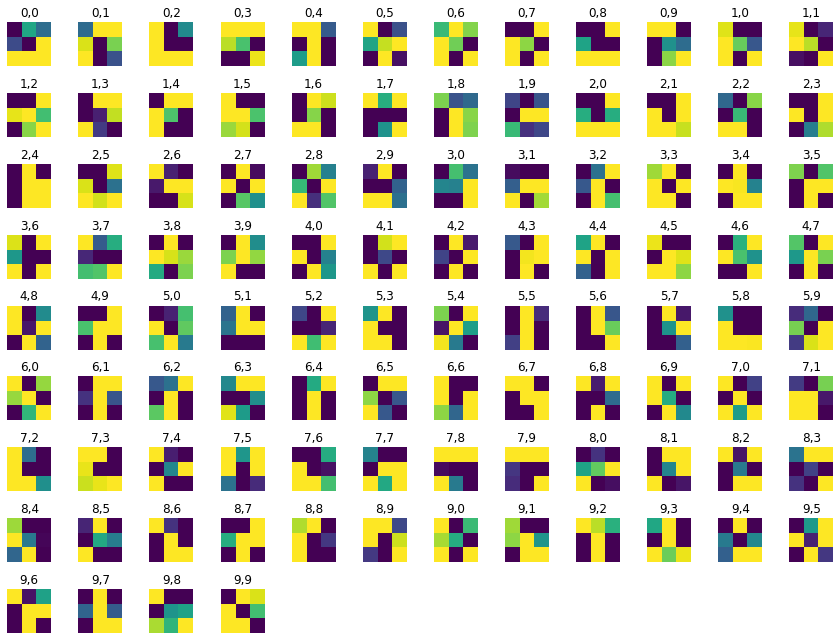

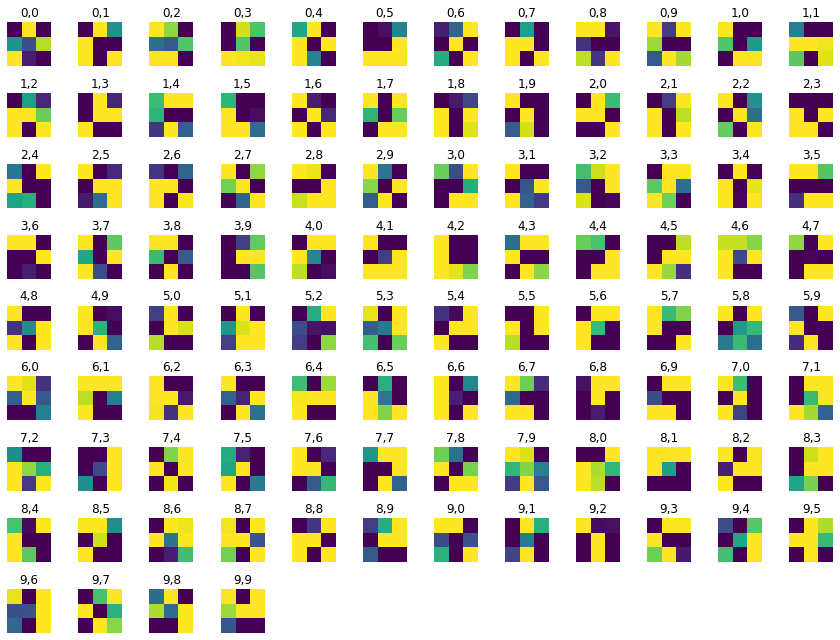

In [278]:
plot_weights(cellnet_1, 0, single_channel = True)
plot_weights(cellnet_1, 3, single_channel = True)
plot_weights(cellnet_1, 6, single_channel = True)

In [306]:

def occlusion(model, image, label, occ_size = 10, occ_stride = 10, occ_pixel = 0.9):
  
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            
            prob = output.squeeze().tolist()[label]
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap

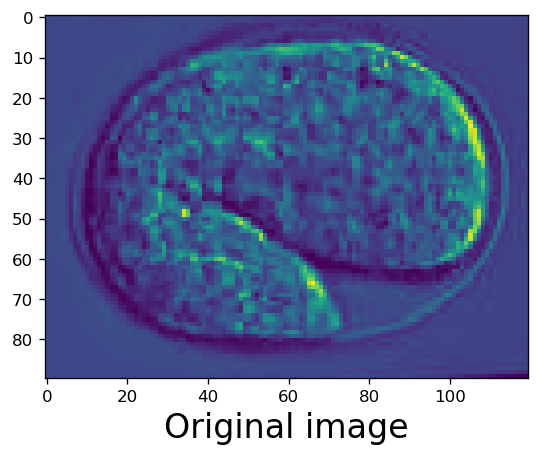

In [340]:
plt.rcParams['figure.dpi'] = 120
inp = preprocess("c2.jpg", show = True)

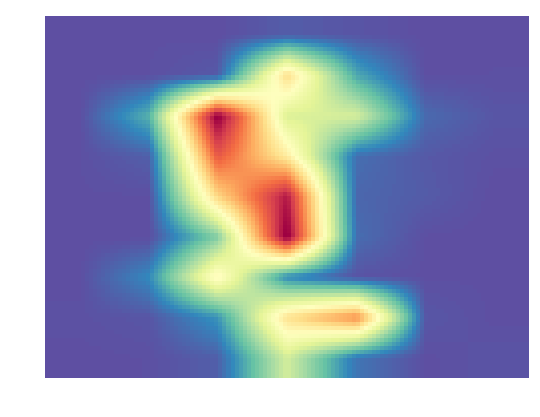

In [341]:
heatmap = occlusion(cellnet_1, inp, 2, 12, 12).numpy()
overlay = cv2.resize(heatmap, (120,90))
plt.imshow(overlay, cmap = "Spectral_r")

plt.axis('off')

plt.show()
plt.imsave("heat.jpg", overlay)


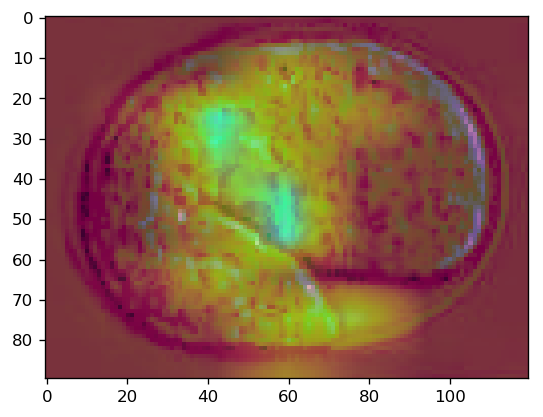

In [342]:
img = cv2.resize(cv2.imread("cell_2.jpg"), (120,90))
mapp= cv2.resize(cv2.imread("heat.jpg"), (120,90))

fin = cv2.addWeighted(img, 0.5, mapp, 0.7, 0)

plt.imshow(fin)
plt.show()